# <div style="color: DarkCyan">Case Study 1: Bank Marketing</div>

**Business case:** We need a way to pick the right customers to sell our bank product!

**Data source:** <a href='https://archive.ics.uci.edu/ml/datasets/bank+marketing#' target='_blank'>UCI Machine Learning Repository</a>

**Related publications:**
    - S. Moro, P. Cortez and P. Rita. A Data-Driven Approach to Predict the Success of Bank Telemarketing. Decision Support Systems, Elsevier, 62:22-31, June 2014
    - S. Moro, R. Laureano and P. Cortez. Using Data Mining for Bank Direct Marketing: An Application of the CRISP-DM Methodology. In P. Novais et al. (Eds.), Proceedings of the European Simulation and Modelling Conference - ESM'2011, pp. 117-121, Guimaraes, Portugal, October, 2011

In [3]:
%run ./utils

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Extracting data
*Data has to come from somewhere!*

We pull the data from a url link. To our convenience, pandas can recognize whether the path we enter to `read_csv` is a local file or a link to a remote resource.

In [5]:
# Import from a url link
marketing = pd.read_csv(
    'https://s3-us-west-2.amazonaws.com/big-data-expert-ii-data/bank-marketing/bank-additional-full.csv', 
    sep=';')

## First look at the data
*Just out of curiosity & sanity check.*

We print a random sample from the dataset and eyeball the columns and their values. Checking the data types of the values helps us quickly spot false parsing of the dataset. 

In [10]:
display_pandas(marketing.sample(5))

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
36895,39,student,single,unknown,no,yes,no,cellular,jun,fri,474,3,999,0,nonexistent,-2.9,92.963,-40.8,1.224,5076.2,yes
21608,41,blue-collar,divorced,basic.9y,no,no,no,cellular,aug,tue,102,1,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,no
33078,28,student,single,university.degree,unknown,yes,no,cellular,may,tue,116,2,999,0,nonexistent,-1.8,92.893,-46.2,1.291,5099.1,no
15579,29,admin.,single,university.degree,no,no,no,telephone,jul,fri,277,1,999,0,nonexistent,1.4,93.918,-42.7,4.957,5228.1,no
37113,47,admin.,married,university.degree,no,no,no,telephone,jul,tue,186,9,999,0,nonexistent,-2.9,92.469,-33.6,0.908,5076.2,no


In [11]:
display_pandas(pd.DataFrame(marketing.dtypes, columns=['types'])
    .reset_index()
    .groupby('types')
    .agg({'index': lambda c: c.str.cat(sep=', ')}))

,index
types,
int64,"age, duration, campaign, pdays, previous"
float64,"emp.var.rate, cons.price.idx, cons.conf.idx, euribor3m, nr.employed"
object,"job, marital, education, default, housing, loan, contact, month, day_of_week, poutcome, y"


## Make the target variable numeric

In order to get a feeling of how the data set performs while performing cleaning and transformations, we will periodiacally run the `simple_classification_performance` function which trains and evaluates a simple machine learning model (logistic regression or random forest). 

To be able to do that, we first transform the target variable to numeric. 

In [12]:
# Check that the labels are valid
display_numpy(marketing.y.unique(), 'y')

,y
0,no
1,yes


In [13]:
marketing_labels = (marketing.y == 'yes').astype(int)

In [14]:
display_numpy(marketing_labels.unique(), 'y')

,y
0,0
1,1


## Numeric variables
*Integers, real numbers, ...*

We begin by dealing with the numeric variables. We validate that each variable values make sense and then scale them.

In [34]:
# Isolate numeric variables
display_pandas(marketing.select_dtypes(['number']).head())

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,56,261,1,999,0,1.1,93.994,-36.4,4.857,5191.0
1,57,149,1,999,0,1.1,93.994,-36.4,4.857,5191.0
2,37,226,1,999,0,1.1,93.994,-36.4,4.857,5191.0
3,40,151,1,999,0,1.1,93.994,-36.4,4.857,5191.0
4,56,307,1,999,0,1.1,93.994,-36.4,4.857,5191.0


After looking at the definition of the data, we notice that `duration` describes the duration of the corresponding call. This information will not be available before the prediction, thus we have to remove it.

In [35]:
# Remove duration
marketing_numeric = marketing.select_dtypes(['number']).drop('duration', axis=1)

### Missing and invalid values

Looking in the data description, we notice that `pdays` counts the number of days form the last communication with the customer and if there was none, then its value is 999. Nevertheless, there are 4110 inconsistent cases, where the `pdays` is 999 and `previous` is not 0.

To check what is going on, we look at the categorical variable `poutcome` which is undefined when there was no previous contact. We notice that it agrees with `previous`, we replace the incorrect values of `pdays` with the average number of days since the last contact.

In [36]:
display_pandas(marketing_numeric.describe())

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


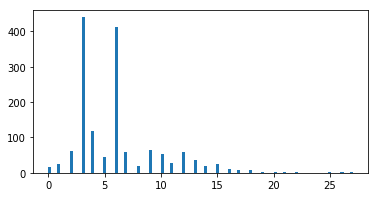

In [37]:
plt.clf()

plt.figure(figsize=(6, 3))
plt.hist(marketing_numeric.pdays[marketing_numeric.pdays != 999], bins=100)

display_plot()

In [38]:
plt.clf()

number_of_columns = len(marketing_numeric.columns)

plt.figure(figsize=(15, 50))
for index, column in enumerate(marketing_numeric.columns):
    plt.subplot(number_of_columns, 2, 2 * index + 1)
    marketing_numeric[column].plot(kind='box')
    plt.subplot(number_of_columns, 2, 2 * index + 2)
    marketing_numeric[column].plot(kind='hist', bins=20)
    plt.xlabel(column)

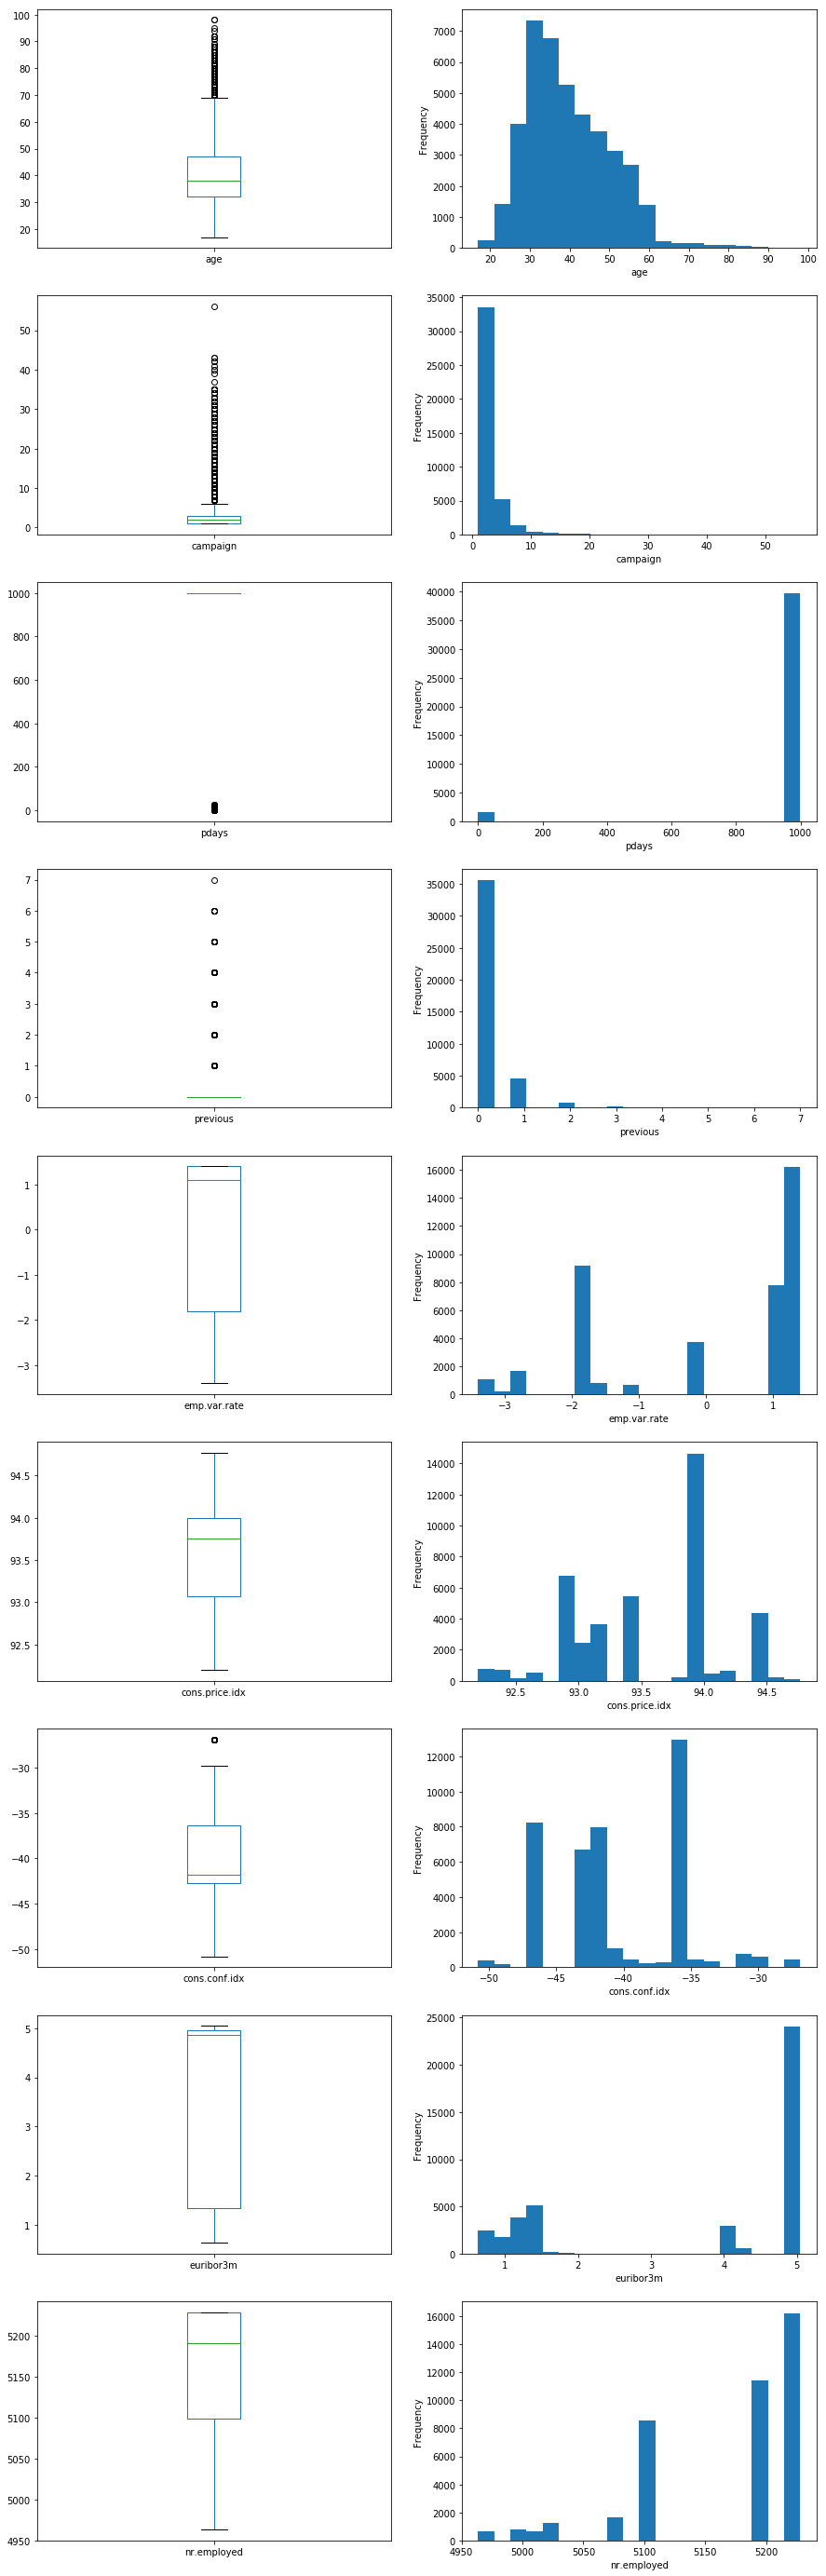

In [39]:
display_plot()

### Remove pdays variable to be used as categorical

In [40]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataTypesSelector(BaseEstimator, TransformerMixin):
    def __init__(self, dtypes=None, drop_columns=[], keep_columns=[]):
        self.dtypes = dtypes
        self.drop_columns = drop_columns
        self.keep_columns = keep_columns
        
    def fit(self, X):
        return self
    
    def transform(self, X):
        return pd.concat(
            [(X.select_dtypes(self.dtypes) if self.dtypes else X).drop(self.drop_columns, axis=1),
              X[self.keep_columns]],
            axis=1)

In [41]:
marketing_numeric_no_pdays = DataTypesSelector(['number'], drop_columns=['duration', 'pdays']).fit_transform(marketing)
display_pandas(marketing_numeric_no_pdays.head())

,age,campaign,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,56,1,0,1.1,93.994,-36.4,4.857,5191.0
1,57,1,0,1.1,93.994,-36.4,4.857,5191.0
2,37,1,0,1.1,93.994,-36.4,4.857,5191.0
3,40,1,0,1.1,93.994,-36.4,4.857,5191.0
4,56,1,0,1.1,93.994,-36.4,4.857,5191.0


## Our first run


Selecting regularization parameter...
Using hyperparameter=10
Evaluating model on 10 folds...



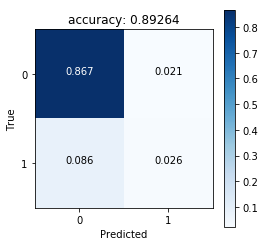

In [42]:
_ = simple_classification_performance(
    marketing_numeric_no_pdays, 
    marketing_labels, 
    model_name='random_forest', 
    grid={'max_depth': [10]}, 
    run_grid_search=False)

### Scale the variables to the interval [0, 1]

In [43]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

numeric_pipeline = Pipeline([
    ('selector', DataTypesSelector(dtypes=['number'], drop_columns=['duration', 'pdays'])),
    ('scaler', MinMaxScaler())
])

numeric_scaled = numeric_pipeline.fit_transform(marketing)


Selecting regularization parameter...
Using hyperparameter=10
Evaluating model on 10 folds...



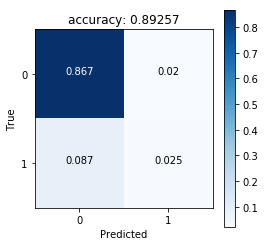

In [44]:
_ = simple_classification_performance(
    numeric_scaled, 
    marketing_labels, 
    model_name='random_forest', 
    grid={'max_depth': [10]},
    run_grid_search=False)

## Categorical values

### Handle pdays
We notice that the values of pdays fall roughly in three intervals: [0, 5], (5, 28] and (28, 999]

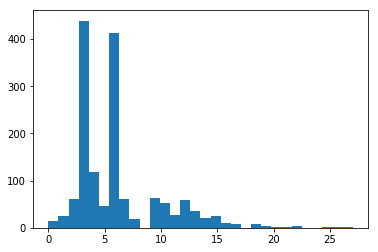

In [45]:
plt.hist(marketing.pdays[marketing.pdays != 999], bins=30)

display_plot()

In [46]:
class Discretizer(BaseEstimator, TransformerMixin):
    def __init__(self, intervals, labels, column):
        self.intervals = intervals
        self.labels = labels
        self.column = column
        
    def fit(self, X):
        return self
    
    def transform(self, X):
        return pd.concat([
            X.drop(self.column, axis=1), 
            pd.cut(X[self.column], self.intervals, labels=self.labels)], axis=1)

In [47]:
marketin_pdays_raw = DataTypesSelector(
    ['O'], 
    drop_columns=['y'], 
    keep_columns=['pdays']).transform(marketing)

marketing_categorical = Discretizer([-1, 5, 28, 1000], range(3), 'pdays').transform(marketin_pdays_raw)

In [48]:
display_pandas(marketing_categorical.head())

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,pdays
0,housemaid,married,basic.4y,no,no,no,telephone,may,mon,nonexistent,2
1,services,married,high.school,unknown,no,no,telephone,may,mon,nonexistent,2
2,services,married,high.school,no,yes,no,telephone,may,mon,nonexistent,2
3,admin.,married,basic.6y,no,no,no,telephone,may,mon,nonexistent,2
4,services,married,high.school,no,no,yes,telephone,may,mon,nonexistent,2


### Missing or invalid values
After a first pass over the categorical variables, we see there are no missing values. After a closer look at the job variable, we notice that the missing values are marked with the string `unknown`. We replace them with the actual null value of numpy and then substitute with the most frequent value.

In [49]:
display_pandas_str(marketing_categorical.describe())

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,pdays
count,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188
unique,12,4,8,3,3,3,2,10,5,3,3
top,admin.,married,university.degree,no,yes,no,cellular,may,thu,nonexistent,2
freq,10422,24928,12168,32588,21576,33950,26144,13769,8623,35563,39673


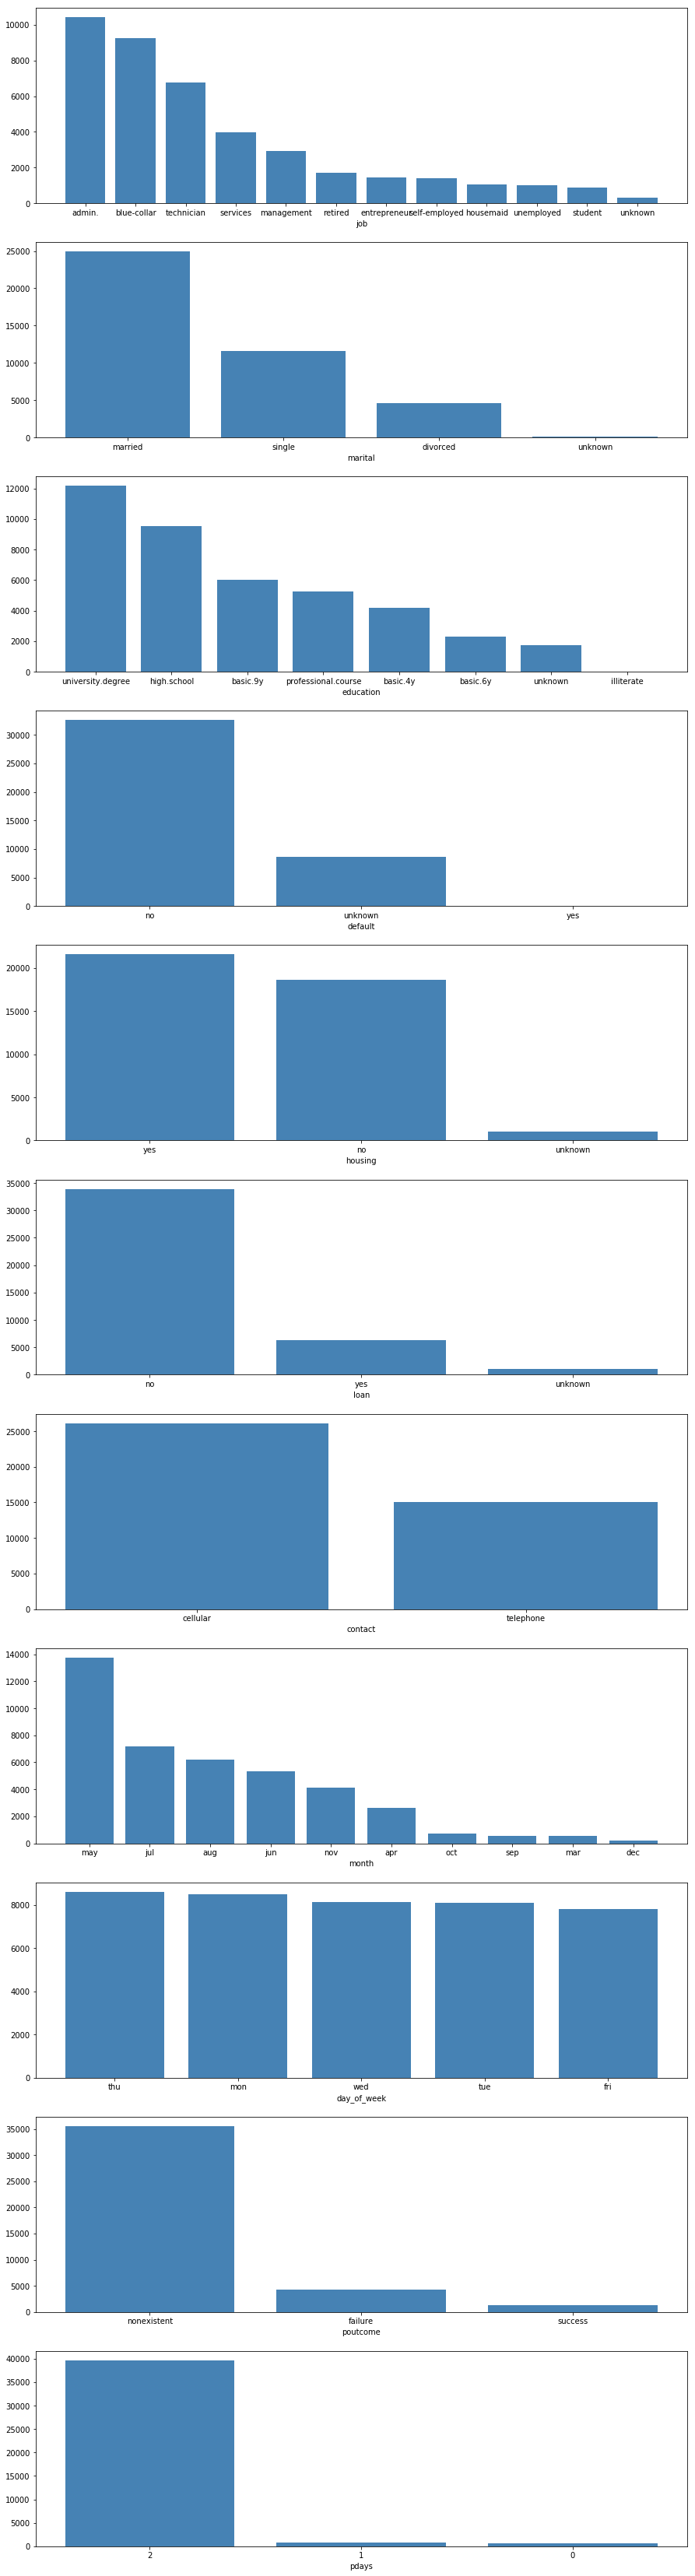

In [50]:
import matplotlib.pyplot as plt
plt.clf()

plt.figure(figsize=(15, 60))
for index, column in enumerate(marketing_categorical.columns):
    value_counts = marketing_categorical[column].value_counts()
    plt.subplot(len(marketing_categorical.columns), 1, index + 1)
    plt.bar(range(len(value_counts)), value_counts.values, color="steelblue")
    plt.xticks(range(len(value_counts)), value_counts.index.tolist())
    plt.xlabel(column)
    
display_plot()

In [51]:
display_numpy((marketing_categorical == 'unknown').sum(), 'unknown')

,unknown
job,330
marital,80
education,1731
default,8597
housing,990
loan,990
contact,0
month,0
day_of_week,0
poutcome,0


In [52]:
display_numpy(marketing_categorical.isnull().sum(), 'nan')

,nan
job,0
marital,0
education,0
default,0
housing,0
loan,0
contact,0
month,0
day_of_week,0
poutcome,0


In [53]:
class CategoricalImputer(BaseEstimator, TransformerMixin):
    def __init__(self, nan_value):
        self.nan_value = nan_value
        
    def fit(self, X):
        self.most_frequent = X.apply(lambda df: df.value_counts().idxmax())
        return self
    
    def transform(self, X):
        return X.replace(self.nan_value, np.nan).fillna(self.most_frequent)

In [54]:
# Replace nulls with the most frequent value
marketing_categorical_no_nulls = CategoricalImputer('unknown').fit_transform(marketing_categorical)

In [55]:
display_numpy(
    marketing_categorical_no_nulls.apply(lambda x: ', '.join(x.unique().astype(str).tolist())), 
    'categories')

,categories
job,"housemaid, services, admin., blue-collar, technician, retired, management, unemployed, self-employed, entrepreneur, student"
marital,"married, single, divorced"
education,"basic.4y, high.school, basic.6y, basic.9y, professional.course, university.degree, illiterate"
default,"no, yes"
housing,"no, yes"
loan,"no, yes"
contact,"telephone, cellular"
month,"may, jun, jul, aug, oct, nov, dec, mar, apr, sep"
day_of_week,"mon, tue, wed, thu, fri"
poutcome,"nonexistent, failure, success"


### Dates

Dates can be very crutial in predictions and usually require some special care when parsing them. Reason why, is that they come in different formats -e.g. 2018-01-23 vs 01/23/2018- or they might even be split in separate columns like in our example.

Here we convert the month and day of week to ordinal variables.

In [56]:
# Make the month and day numeric
month = marketing.month.replace(('jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec'),range(1, 13))
week_day = marketing.day_of_week.replace(('mon','tue','wed','thu','fri'),range(1, 6))

In [57]:
class DateTimeHandler(BaseEstimator, TransformerMixin):
    def fit(self, X):
        return self
    
    def transform(self, X):
        month = X.month.replace(('jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec'),range(1, 13))
        week_day = X.day_of_week.replace(('mon','tue','wed','thu','fri'),range(1, 6))
        
        return pd.concat([
            X.drop(['month', 'day_of_week'], axis=1), 
            month,
            week_day], axis=1)

In [58]:
# Gather the date-related variables
date_variables = DateTimeHandler().transform(marketing_categorical_no_nulls)
display_pandas(date_variables.sample(5))

,job,marital,education,default,housing,loan,contact,poutcome,pdays,month,day_of_week
7380,services,married,high.school,no,no,yes,telephone,nonexistent,2,5,5
4895,admin.,married,high.school,no,yes,no,telephone,nonexistent,2,5,3
33863,admin.,married,university.degree,no,yes,no,cellular,nonexistent,2,5,3
16912,admin.,married,university.degree,no,no,no,cellular,nonexistent,2,7,4
27215,unemployed,single,basic.4y,no,no,yes,cellular,nonexistent,2,11,5


### Education
Education is an ordinal value. We can infer the ordering to convert to a numeric variable.

In [59]:
display_numpy(marketing_categorical_no_nulls.education.unique(), "education")

,education
0,basic.4y
1,high.school
2,basic.6y
3,basic.9y
4,professional.course
5,university.degree
6,illiterate


In [60]:
class OrdinalTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, mapping, column):
        self.mapping = mapping
        self.column = column
        
    def fit(self, X):
        return self
    
    def transform(self, X):
        return transform_column(X, self.column, lambda col: col.replace(self.mapping))

In [61]:
education = OrdinalTransformer({
        'illiterate': 1, 
        'basic.4y': 2, 
        'basic.6y': 3, 
        'basic.9y': 4, 
        'high.school': 5, 
        'professional.course': 6, 
        'university.degree': 7},
    'education').transform(marketing_categorical_no_nulls)

### One hot encoding
We can convert the rest of the categorical variables to numeric by creating one column for each category which has the value 0 or 1 depending on whether the sample belongs to the corresponding category or not.

In [62]:
class CategoricalOneHotEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X):
        self.columns = pd.get_dummies(X).columns
        return self
    
    def transform(self, X):
        return pd.get_dummies(X).reindex(columns=self.columns, fill_value=0)

In [63]:
marketing_non_ordinal = DataTypesSelector(drop_columns=['month', 'day_of_week', 'education']).fit_transform(marketing_categorical_no_nulls)

marketing_ohe = CategoricalOneHotEncoder().fit_transform(marketing_non_ordinal)

In [64]:
display_pandas(marketing_ohe.head())

,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,marital_divorced,marital_married,marital_single,default_no,default_yes,housing_no,housing_yes,loan_no,loan_yes,contact_cellular,contact_telephone,poutcome_failure,poutcome_nonexistent,poutcome_success,pdays_0,pdays_1,pdays_2
0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,1,0,1,0,0,1,0,1,0,0,0,1
1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,1,0,1,0,0,1,0,1,0,0,0,1
2,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,1,0,0,1,0,1,0,0,0,1
3,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,1,0,0,1,0,1,0,0,0,1
4,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,1,0,0,1,0,1,0,1,0,0,0,1


### Merge categorical data
Now that we are done with all transforms, we can go on and merge the ordinal with the rest of the categorical variables. To do that, we will use the `FeatureUnion` class of the sklearn pipelines.

In [65]:
class DataframeSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        
    def fit(self, X):
        return self
    
    def transform(self, X):
        return X[self.columns]

In [66]:
from sklearn.pipeline import FeatureUnion

education_ordinal_map ={
    'illiterate': 1, 
    'basic.4y': 2, 
    'basic.6y': 3, 
    'basic.9y': 4, 
    'high.school': 5, 
    'professional.course': 6, 
    'university.degree': 7}

categorical_initial_pipeline = Pipeline([
    ('selector', DataTypesSelector(['O'], drop_columns=['y'], keep_columns='pdays')),
    ('discretizer', Discretizer([-1, 5, 28, 1000], range(3), 'pdays')), 
    ('imputer', CategoricalImputer('unknown'))
])

ordinal_pipeline = Pipeline([
    ('selector', DataframeSelector(['month', 'day_of_week', 'education'])),
    ('ordinal_transformer', OrdinalTransformer(education_ordinal_map, 'education')),
    ('datetime_handler', DateTimeHandler())
])

ohe_pipeline = Pipeline([
    ('selector', DataframeSelector(['job', 'marital', 'default', 'housing', 'loan', 'contact', 'poutcome', 'pdays'])),
    ('ohe_encoder', CategoricalOneHotEncoder())
])

categorical_pipeline = Pipeline([
    ('initial_pipeline', categorical_initial_pipeline),
    ('merge_ordinal_ohe', FeatureUnion([('ordinal', ordinal_pipeline), ('ohe', ohe_pipeline)], n_jobs=-1))
])

In [67]:
marketing_categorical_preprocessed = categorical_pipeline.fit_transform(marketing)

In [68]:
marketing_categorical_preprocessed.shape

(41188, 31)


Selecting regularization parameter...
Using hyperparameter=10
Evaluating model on 10 folds...



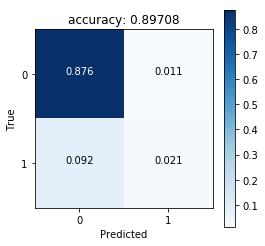

In [69]:
_ = simple_classification_performance(
    marketing_categorical_preprocessed, 
    marketing_labels, 
    model_name='random_forest',
    grid={'max_depth': [10]},
    run_grid_search=False)

## Numeric and categorical together
We merge the preprocessed numeric and categorical data to get our final preprocessed data set. After running our simple classifier we notice the increase in performance. 

In [70]:
pipeline = FeatureUnion([
    ('numeric', numeric_pipeline),
    ('categorical', categorical_pipeline)], n_jobs=-1)

In [71]:
marketing_preprocessed = pipeline.fit_transform(marketing)

In [72]:
marketing_preprocessed.shape

(41188, 39)


Selecting regularization parameter...
Using hyperparameter=10
Evaluating model on 10 folds...



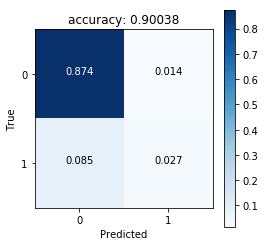

In [73]:
final_model = simple_classification_performance(
    marketing_preprocessed, 
    marketing_labels, 
    model_name='random_forest',
    grid={'max_depth': [10]},
    run_grid_search=False)

## Try it out!

In [74]:
# First split the dataset to train and test
from sklearn.model_selection import train_test_split

train_features, test_features, train_labels, test_labels = train_test_split(marketing, marketing_labels, random_state=42)

In [75]:
# The power of pipelines
train_preprocessed_features = pipeline.transform(train_features.reset_index(drop=True))

_ = final_model.fit(train_preprocessed_features, train_labels.reset_index(drop=True))

In [76]:
def predict(datapoint):
    return final_model.predict_proba(pipeline.transform(pd.DataFrame(datapoint)[marketing.columns]))

In [77]:
marketing[:1].to_dict(orient='list')

{'age': [56],
 'campaign': [1],
 'cons.conf.idx': [-36.4],
 'cons.price.idx': [93.994],
 'contact': ['telephone'],
 'day_of_week': ['mon'],
 'default': ['no'],
 'duration': [261],
 'education': ['basic.4y'],
 'emp.var.rate': [1.1],
 'euribor3m': [4.857],
 'housing': ['no'],
 'job': ['housemaid'],
 'loan': ['no'],
 'marital': ['married'],
 'month': ['may'],
 'nr.employed': [5191.0],
 'pdays': [999],
 'poutcome': ['nonexistent'],
 'previous': [0],
 'y': ['no']}

In [78]:
predict({'age': [80],
 'campaign': [2],
 'cons.conf.idx': [-36.4],
 'cons.price.idx': [93.994],
 'contact': ['telephone'],
 'day_of_week': ['wed'],
 'default': ['no'],
 'duration': [4],
 'education': ['basic.4y'],
 'emp.var.rate': [1.1],
 'euribor3m': [4.857],
 'housing': ['yes'],
 'job': ['housemaid'],
 'loan': ['no'],
 'marital': ['divorced'],
 'month': ['jul'],
 'nr.employed': [3000.0],
 'pdays': [1],
 'poutcome': ['success'],
 'previous': [50],
 'y': ['no']})

array([[0.47517065, 0.52482935]])

## The business case
*Because we want to get value out of it!*

In [79]:
print('Success ratio before using predictions: {:.2f}'.format((marketing.y == 'yes').sum() / float(marketing.shape[0])))

Success ratio before using predictions: 0.11


In [80]:
test_labels = marketing_labels[test_features.index]
predictions = final_model.predict(pipeline.transform(test_features))
number_of_correct_predictions = (test_labels[predictions == 1]).sum()

print('Success ratio with predictions: {:.2f}'.format(number_of_correct_predictions / float(predictions.sum())))

Success ratio with predictions: 0.66


In [81]:
print('Rejection ratio: {:.2f}'.format(test_labels[predictions == 0].sum() / test_labels.sum()))

Rejection ratio: 0.76


- Almost 500% success increase! - though we have to reject ~2/3 of the market
- Less costs for marketing 
- Flexibility to choose an optimal threshold given the size of the market